In [10]:
from data_fns import frequency_detection
from estimator import RFClassifier, classical_weights, haltere_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [5]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

Client Scheduler: tcp://127.0.0.1:45345 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 25 Memory: 67.32 GB


In [6]:
# load data
n_samples, fs, signal_duration, k, a = 5000, 1500, 0.1, 5, 0.8
X, y = frequency_detection(n_samples, fs, k, signal_duration, a, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))

# weight params
kwargs = {'lowcut': 2, 'highcut': 8}
weights_halteres = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights}

# params for classification
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
b = np.mean(la.norm(X_train)/ np.sqrt(X.shape[0]))

In [11]:
results = {}
l = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
results['halteres'] = {'avg_test_err': l.copy(), 'std_test_err': l.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                   params_classical, 
                                                                                                   X_train, y_train, 
                                                                                                   X_test, y_test, 
                                                                                                   n_iters=5)
    
    # haltere inspired
    params_halteres = {'width': n, **weights_halteres, 'bias': b, 'nonlinearity': relu, 'clf': sgd} 
    _, _, results['halteres']['avg_test_err'][i], results['halteres']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                            params_halteres, 
                                                                                                            X_train, y_train, 
                                                                                                            X_test, y_test, 
                                                                                                            n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
with open('results/freq_detection/freq_clf.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 


Iter: 0/42
Iter: 1/42
Iter: 2/42
Iter: 3/42
Iter: 4/42
Iter: 5/42
Iter: 6/42
Iter: 7/42
Iter: 8/42
Iter: 9/42
Iter: 10/42
Iter: 11/42
Iter: 12/42
Iter: 13/42
Iter: 14/42
Iter: 15/42
Iter: 16/42
Iter: 17/42
Iter: 18/42
Iter: 19/42
Iter: 20/42
Iter: 21/42
Iter: 22/42
Iter: 23/42
Iter: 24/42
Iter: 25/42
Iter: 26/42
Iter: 27/42
Iter: 28/42
Iter: 29/42
Iter: 30/42
Iter: 31/42
Iter: 32/42
Iter: 33/42
Iter: 34/42
Iter: 35/42
Iter: 36/42
Iter: 37/42
Iter: 38/42
Iter: 39/42
Iter: 40/42
Iter: 41/42


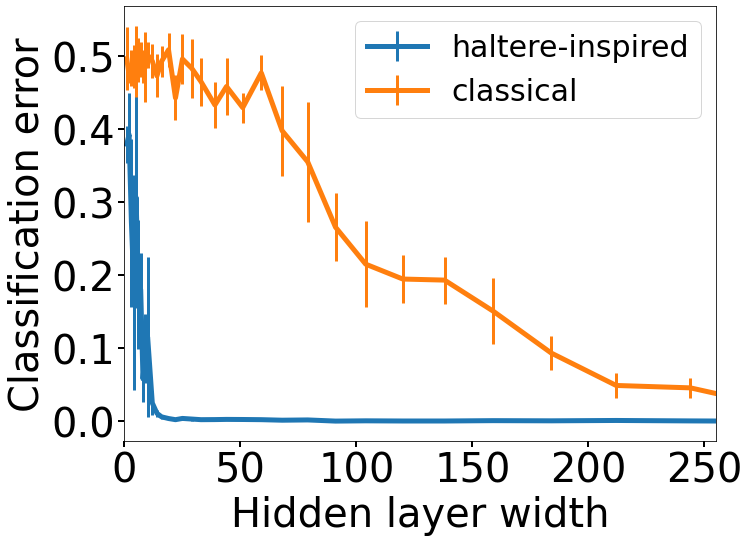

In [16]:
with open('results/freq_detection/freq_clf.pickle', 'rb') as handle:
    results = pickle.load(handle) 
    
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['halteres']['avg_test_err'], yerr=results['halteres']['std_test_err'], 
            fmt='-', label='haltere-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([0, 0.55])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)

In [ ]:
W = haltere_inspired_weights(20, 150, 3, 5, scale=1)
W1 = classical_weights(20, 150, scale=1)
np.mean(la.norm(W, axis=1)), np.mean(la.norm(W1, axis=1))

In [ ]:
fig = plt.figure()
plt.plot(X_train[0], 'k')
plt.plot(W[4])
plt.plot(W1[4])